# **Data Exploration**
**Objective:** To understand the data structure, identify fraud patterns, and select key features for modeling. 

**Technical Requirements:** STRICTLY use NumPy, Matplotlib, and Seaborn. NO Pandas allowed.

## **Setup & Import**

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..')) # Correlation Matrix (NumPy style)
import numpy as np
from src.data_processing import load_csv_numpy, check_missing, calculate_t_test
from src.visualization import plot_histogram, plot_confusion_matrix # Borrowing a heatmap to draw corners
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # Using for draw 3D Image
sns.set_style("whitegrid")

---

## **Load and Inspect Data**
The `creditcard.csv` dataset contains credit card transactions.
- **Input:** Raw CSV file.
- **Output:** NumPy Matrix `X` (Features) and Vector `y` (Labels).

In [2]:
# Load data using custom function (handles quote issues in CSV)
header, data = load_csv_numpy('../data/raw/creditcard.csv')

print(f"Dataset Shape: {data.shape}")
print(f"Feature Names: {header}")

# Separate Features and Label
# Structure: Time (col 0), V1-V28 (cols 1-28), Amount (col 29), Class (col 30)
X = data[:, :-1]
y = data[:, -1]

print("\n--- Sample Data (First Row) ---")
print(X[0])

Dataset Shape: (284807, 31)
Feature Names: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

--- Sample Data (First Row) ---
[ 0.00000000e+00 -1.35980713e+00 -7.27811733e-02  2.53634674e+00
  1.37815522e+00 -3.38320770e-01  4.62387778e-01  2.39598554e-01
  9.86979013e-02  3.63786970e-01  9.07941720e-02 -5.51599533e-01
 -6.17800856e-01 -9.91389847e-01 -3.11169354e-01  1.46817697e+00
 -4.70400525e-01  2.07971242e-01  2.57905802e-02  4.03992960e-01
  2.51412098e-01 -1.83067779e-02  2.77837576e-01 -1.10473910e-01
  6.69280749e-02  1.28539358e-01 -1.89114844e-01  1.33558377e-01
 -2.10530535e-02  1.49620000e+02]


---

## **Class Imbalance Analysis**
How severe is the imbalance in the dataset? How does this affect metric selection?

Normal Transactions (0): 284315
Fraud Transactions (1):    492
Fraud Rate: 0.173%


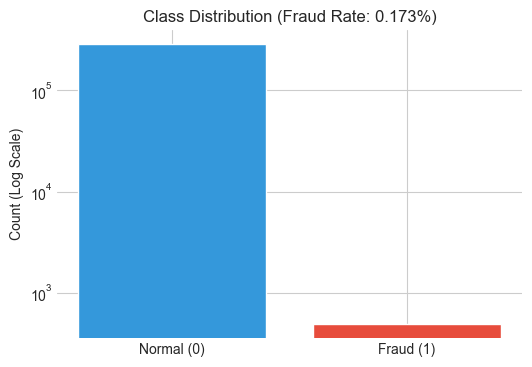

In [3]:
unique, counts = np.unique(y, return_counts=True)
count_dict = dict(zip(unique, counts))

n_normal = int(count_dict.get(0.0, 0))
n_fraud = int(count_dict.get(1.0, 0))
total = n_normal + n_fraud
fraud_rate = (n_fraud / total) * 100

print(f"Normal Transactions (0): {n_normal}")
print(f"Fraud Transactions (1):    {n_fraud}")
print(f"Fraud Rate: {fraud_rate:.3f}%")

# Visualization
plt.figure(figsize=(6, 4))
bars = plt.bar(['Normal (0)', 'Fraud (1)'], [n_normal, n_fraud], color=['#3498db', '#e74c3c'])
plt.title(f'Class Distribution (Fraud Rate: {fraud_rate:.3f}%)')
plt.yscale('log') # Use Log Scale to make the Fraud bar visible
plt.ylabel('Count (Log Scale)')
plt.show()

### **Analysis:**
- The fraud rate is extremely low (**0.173%**).
- **Consequence:** If the model predicts "Normal" for everything, Accuracy will still be 99.8% but the model is useless. We must focus on **Precision, Recall, and F1-Score**.

---

## **Time Analysis**
Do fraudsters operate during specific hours of the day?

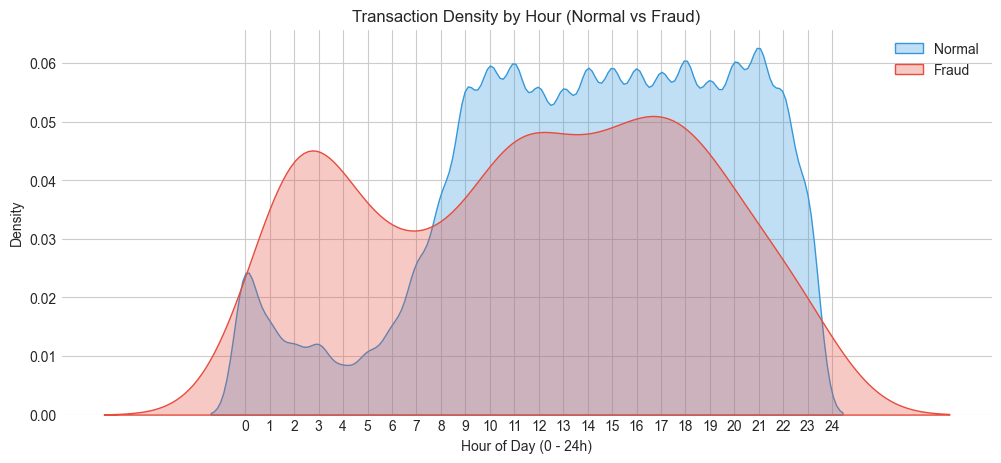

In [4]:
# Raw 'Time' is in seconds (from 0 to ~172792s, covering 48 hours)
time_val = X[:, 0]
# Convert to Hour of Day (0-23h)
hours = (time_val // 3600) % 24

# Split groups
hours_normal = hours[y == 0]
hours_fraud = hours[y == 1]

plt.figure(figsize=(12, 5))
# Use density=True to compare distributions regardless of count
sns.kdeplot(hours_normal, label='Normal', fill=True, color='#3498db', alpha=0.3)
sns.kdeplot(hours_fraud, label='Fraud', fill=True, color='#e74c3c', alpha=0.3)

plt.xlabel('Hour of Day (0 - 24h)')
plt.ylabel('Density')
plt.title('Transaction Density by Hour (Normal vs Fraud)')
plt.xticks(np.arange(0, 25, 1))
plt.legend()
plt.show()

### **Analysis:**
**Visual Observation:**
*   **Normal (Blue):** The distribution is bimodal (two peaks). It drops significantly during the night (around index 0 to 5) and peaks during daytime business hours (around index 9-18). This reflects typical human sleep-wake cycles.
*   **Fraud (Red):** The distribution is completely different.
    *   There is a **sharp, distinct peak** early in the morning, specifically around **Hour 2 to Hour 4**.
    *   While normal activity is at its lowest point during these hours, fraud activity is at its highest relative density.
    *   The fraud curve flattens out during the day but remains consistent.

**Insight:**

The visualization reveals a critical behavioral difference. While genuine transactions drop significantly during late-night hours (1 AM - 5 AM), **fraudulent activity peaks specifically between 2 AM and 4 AM**. This suggests that fraudsters (or automated scripts) prefer operating when cardholders are asleep and less likely to notice transaction alerts. This `Time` feature is a strong predictor.


---

## **Amount Analysis & Statistical Testing**
How much money do fraudsters usually withdraw? Is there a "safe zone"?

Mean Amount (Fraud):  $122.21
Mean Amount (Normal): $88.29


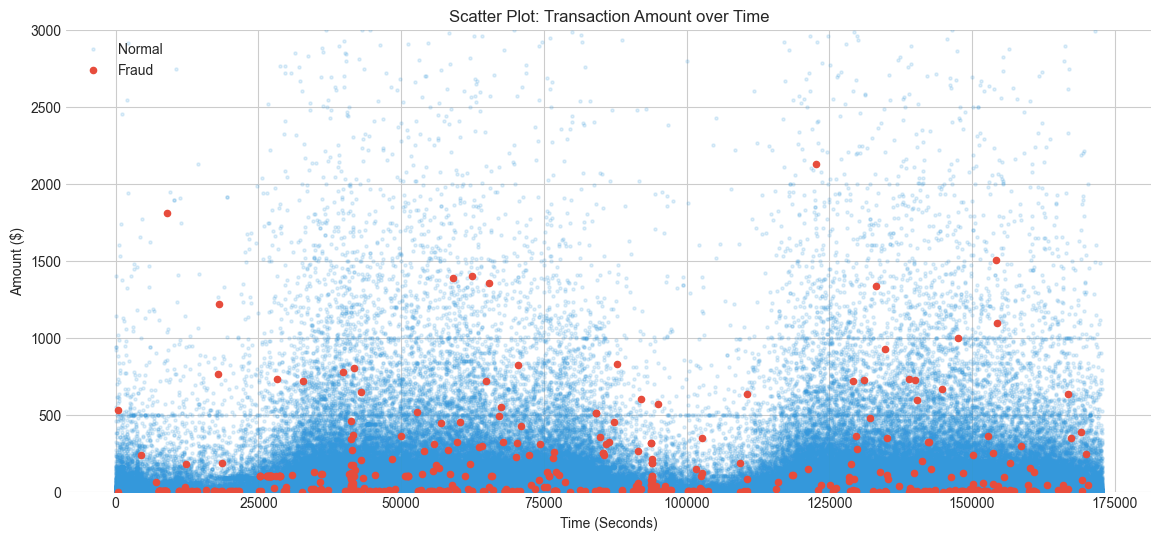

T-statistic for Amount: -2.9288
=> Reject H0. There is a statistically significant difference in transaction amounts.


In [5]:
fraud_amounts = X[y == 1, 29]
normal_amounts = X[y == 0, 29]

print(f"Mean Amount (Fraud):  ${np.mean(fraud_amounts):.2f}")
print(f"Mean Amount (Normal): ${np.mean(normal_amounts):.2f}")

# 1. Scatter Plot: Time vs Amount
plt.figure(figsize=(14, 6))
# Plot Normal first (faint and small)
plt.scatter(X[y==0, 0], X[y==0, 29], c='#3498db', alpha=0.15, s=5, label='Normal')
# Plot Fraud on top (bold and larger)
plt.scatter(X[y==1, 0], X[y==1, 29], c='#e74c3c', alpha=1.0, s=20, label='Fraud')

plt.xlabel('Time (Seconds)')
plt.ylabel('Amount ($)')
plt.title('Scatter Plot: Transaction Amount over Time')
plt.legend()
plt.ylim(0, 3000) # Zoom into the under-$3000 region
plt.show()

# 2. Statistical T-test
# H0: There is no difference in mean Amount between the two groups.
t_stat = calculate_t_test(X, y, feature_idx=29)
print(f"T-statistic for Amount: {t_stat:.4f}")

if abs(t_stat) > 1.96:
    print("=> Reject H0. There is a statistically significant difference in transaction amounts.")
else:
    print("=> Accept H0.")

### **Analysis:**
**Visual Observation:**
*   **Vertical Distribution:** The Red dots (Fraud) are heavily concentrated at the bottom of the Y-axis.
*   **The Ceiling:** There is a visible "hard ceiling" for fraud. While Blue dots (Normal) go all the way up the chart (and beyond the view), the Red dots rarely exceed **$1,500 - $2,000**. The highest visible red dot is just above $2,000.
*   **T-statistic:** The result `-2.9288` confirms the difference is statistically significant.

**Insight:**

Fraudsters are surprisingly conservative with transaction amounts. The scatter plot shows a clear `ceiling`: **almost no fraudulent transactions exceed $2,100**, and the vast majority are **under $500**. They appear to avoid `outlier` amounts that would trigger immediate bank security blocks, preferring smaller, more discreet thefts.

---

## **Feature Selection (Correlation Analysis)**
- Among the anonymous features (V1-V28), which ones are best for classification?
- We use the Pearson correlation coefficient.

--- Top 5 Negative Correlation Features ---
V17: -0.3265
V14: -0.3025
V12: -0.2606
V10: -0.2169
V16: -0.1965

--- Top 5 Positive Correlation Features ---
V4: 0.1334
V2: 0.0913
V21: 0.0404
V19: 0.0348
V20: 0.0201


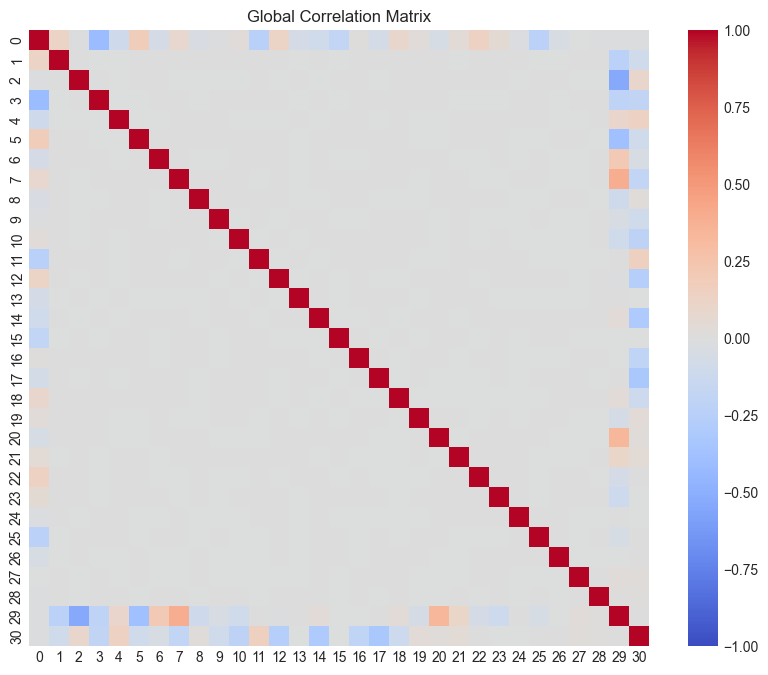

In [6]:
# Calculate Global Correlation Matrix
corr_matrix = np.corrcoef(data, rowvar=False)

# Get correlation with Class column (last column)
class_corr = corr_matrix[:-1, -1]
sorted_idx = np.argsort(class_corr)

print("--- Top 5 Negative Correlation Features ---")
for idx in sorted_idx[:5]:
    print(f"{header[idx]}: {class_corr[idx]:.4f}")

print("\n--- Top 5 Positive Correlation Features ---")
for idx in sorted_idx[-6:-1][::-1]:
    print(f"{header[idx]}: {class_corr[idx]:.4f}")

# Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Global Correlation Matrix')
plt.show()

### **Selection:** 
*   The Global Matrix is mostly gray (neutral), confirming that PCA components (V1-V28) are orthogonal (independent) for the dataset as a whole.
*   **Text Output:** The strongest negative correlations are **V17 (-0.32)**, **V14 (-0.30)**, and **V12 (-0.26)**. The strongest positive is **V4 (0.13)**.

## **Distribution Comparison (Boxplots)**
What is the specific difference between Fraud and Normal groups on the selected features?

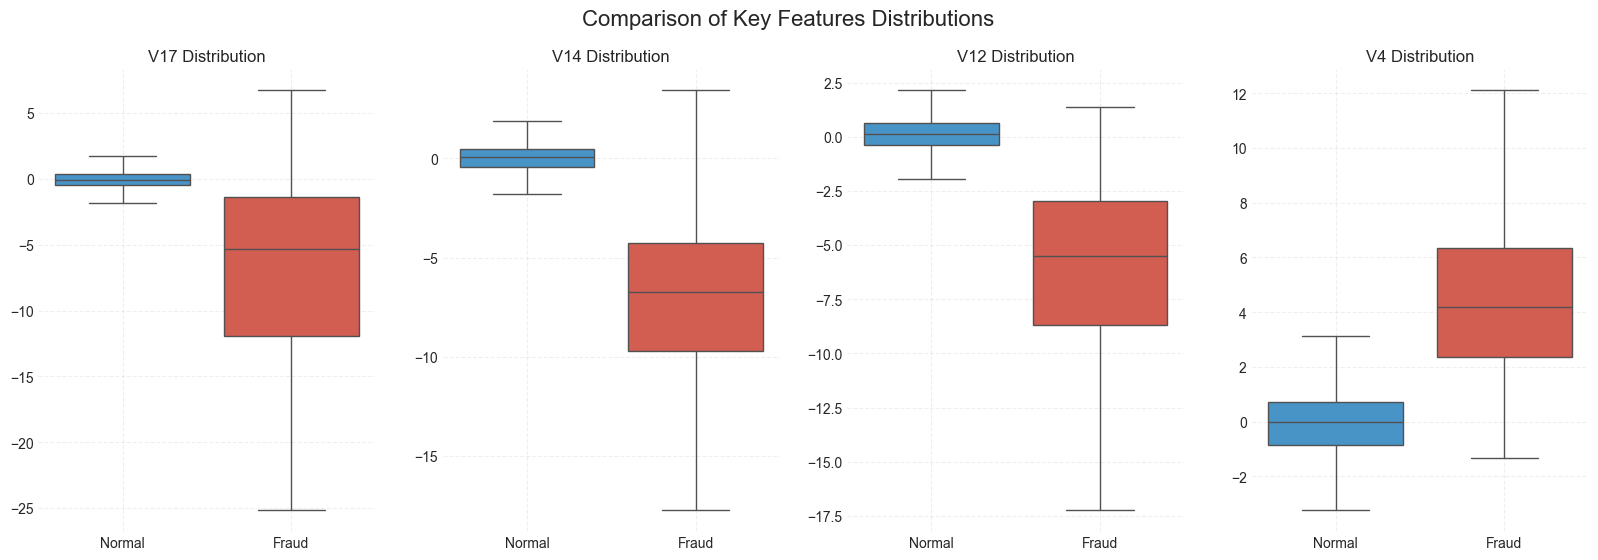

In [7]:
features_to_check = [17, 14, 12, 4]  # Indices for V17, V14, V12, V4
feature_names = ['V17', 'V14', 'V12', 'V4']

fig, axes = plt.subplots(1, 4, figsize=(20, 6))

for i, f_idx in enumerate(features_to_check):
    v_data = X[:, f_idx]
    
    # Add 'hue=y' and 'legend=False' to silence FutureWarning
    sns.boxplot(x=y, y=v_data, ax=axes[i], hue=y, legend=False, 
                palette=['#3498db', '#e74c3c'], showfliers=False)
    
    axes[i].set_title(f'{feature_names[i]} Distribution')
    
    # Set ticks explicitly before setting labels to silence UserWarning
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['Normal', 'Fraud'])
    
    axes[i].grid(True, linestyle='--', alpha=0.3)

plt.suptitle('Comparison of Key Features Distributions', fontsize=16)
plt.show()

### **Analysis:**

**V17, V14, V12 (The "Negative" Indicators):**
- The distinction is crystal clear. For these features, the Fraud distribution (Red box) is shifted significantly downwards.
- **V17:** This is the strongest separator. The median for Fraud is approximately **-5**, and the data extends down to **-25**. In contrast, Normal transactions are tightly clustered around 0.
- **V14 & V12:** Similar behavior, with Fraud medians around -6 and -5 respectively.

**V4 (The "Positive" Indicator):**
- The pattern flips. The Fraud distribution is shifted **upwards**.
- The median for Fraud is approximately **+4**, with values reaching up to **12**. Normal transactions remain near 0.

**Strategic Conclusion:**

The model can easily distinguish fraud by looking for this specific signature: 
- *"Is V17 very low (< -5) AND is V4 high (> 2)?"* 
- This combination acts as a powerful `fingerprint` for fraudulent activity.

---

## **Clustering & Separation**
Do fraud transactions cluster together? If so, simple algorithms can detect them.

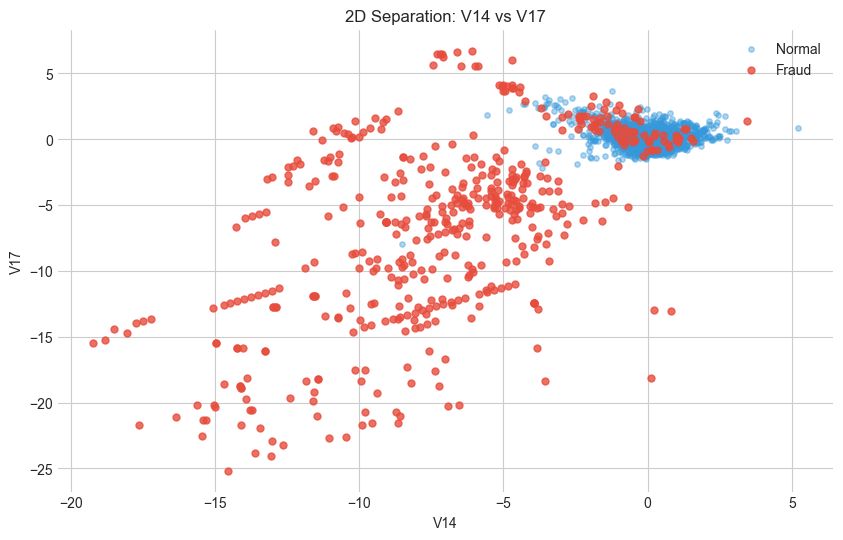

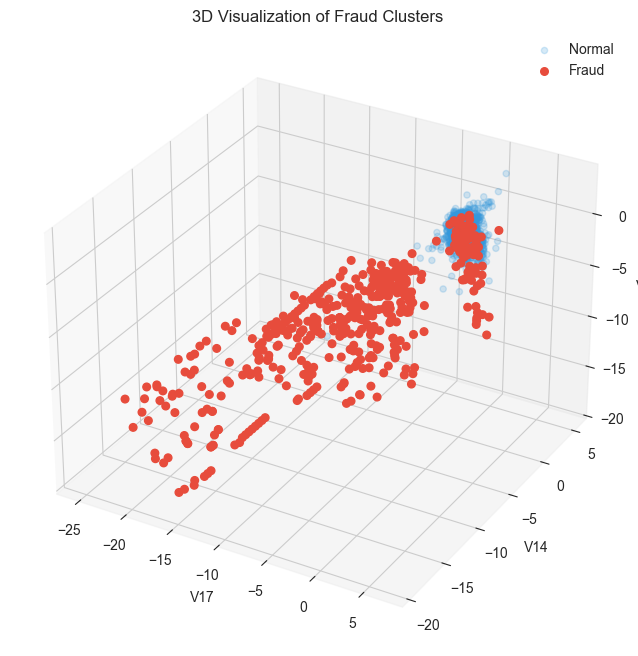

In [8]:
# 1. 2D Scatter Plot: V14 vs V17
v14 = X[:, 14]
v17 = X[:, 17]

# Sample Normal data (too many points to plot all)
idx_norm = np.where(y == 0)[0]
np.random.seed(42)
idx_sample = np.random.choice(idx_norm, 2000, replace=False) # Take 2000 Normal points
idx_fraud = np.where(y == 1)[0] # Take all Fraud points

plt.figure(figsize=(10, 6))
plt.scatter(v14[idx_sample], v17[idx_sample], c='#3498db', alpha=0.4, label='Normal', s=15)
plt.scatter(v14[idx_fraud], v17[idx_fraud], c='#e74c3c', alpha=0.8, label='Fraud', s=25)

plt.xlabel('V14')
plt.ylabel('V17')
plt.title('2D Separation: V14 vs V17')
plt.legend()
plt.grid(True)
plt.show()

# 2. 3D Scatter Plot: V17, V14, V12 (Advanced)
v12 = X[:, 12]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(v17[idx_sample], v14[idx_sample], v12[idx_sample], c='#3498db', alpha=0.2, label='Normal')
ax.scatter(v17[idx_fraud], v14[idx_fraud], v12[idx_fraud], c='#e74c3c', alpha=1.0, s=30, label='Fraud')

ax.set_xlabel('V17')
ax.set_ylabel('V14')
ax.set_zlabel('V12')
ax.set_title('3D Visualization of Fraud Clusters')
plt.legend()
plt.show()

### **Analysis:**
**Visual Observation (2D Image):**
*   The Red dots (Fraud) don't just form a random cloud; they form a **diagonal trajectory** moving from the center down to the bottom-left corner.
*   This indicates that as **V14 decreases**, **V17 also decreases** for fraud cases. They are correlated.

**Visual Observation (3D Image):**
*   The Red cluster is clearly distinguishable from the Blue cloud. It looks like a flattened group extending away from the main data center.

**Insight:**

The 2D and 3D plots demonstrate that fraud transactions are not randomly scattered. They form a **distinct, cohesive cluster** that follows a diagonal trajectory in the vector space. This confirms the data is **linearly separable**, validating the choice of Logistic Regression as a suitable model. We can visualize a clear 'plane' that could slice between the Red and Blue clusters."

---

## **Fraud Internal Correlation Structure**
Does fraud behavior create specific links between variables?

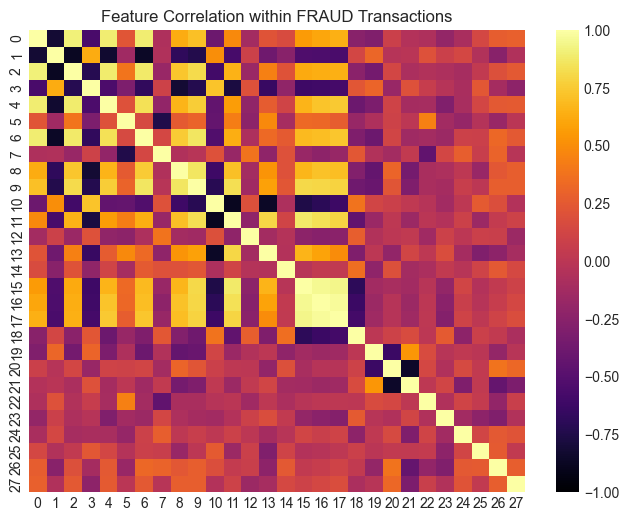

In [9]:
X_fraud = X[y == 1]
corr_fraud = np.corrcoef(X_fraud, rowvar=False)

plt.figure(figsize=(8, 6))
# Heatmap for Fraud group only (Features V1-V28)
sns.heatmap(corr_fraud[1:29, 1:29], cmap='inferno', vmin=-1, vmax=1)
plt.title('Feature Correlation within FRAUD Transactions')
plt.show()

### **Analysis:**
This is a key discovery. While the global dataset shows no correlation between features (due to PCA), the **Fraud subset exhibits strong internal correlations** (visible as bright yellow and dark purple blocks). This implies that fraud is systematic: fraudsters leave a specific 'fingerprint' where changes in one feature (e.g., V17) dictate changes in others (e.g., V14). This structural dependency is a major weakness in their behavior that our model can exploit.